# Project Title

## Introduction

The company Sweet Lift Taxi is looking for a way to improve their business, they have manage to get an historical data of the rides they have done to the airport and from the airport. 

The want to predict the number of rides they will have in the next hour so they can atrract more drivers to the airport when they know they will have a lot of rides.

## Goals

- Predict the number of rides in the next hour

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## Data Loading

In [2]:
data = pd.read_csv('dataset/taxi.csv')

## Data Resampling

In [3]:
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# We check if the index is monotonically increasing
print(df.index.is_monotonic_increasing)

True


In [4]:
# We resample the data to hourly frequency
resampled_data = df.resample('H').sum()

## Data Exploration


In [5]:
resampled_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
resampled_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
resampled_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Data Cleaning and Preparation


In [8]:
resampled_data.isnull().sum()

num_orders    0
dtype: int64

## Exploratory Data Analysis (EDA)


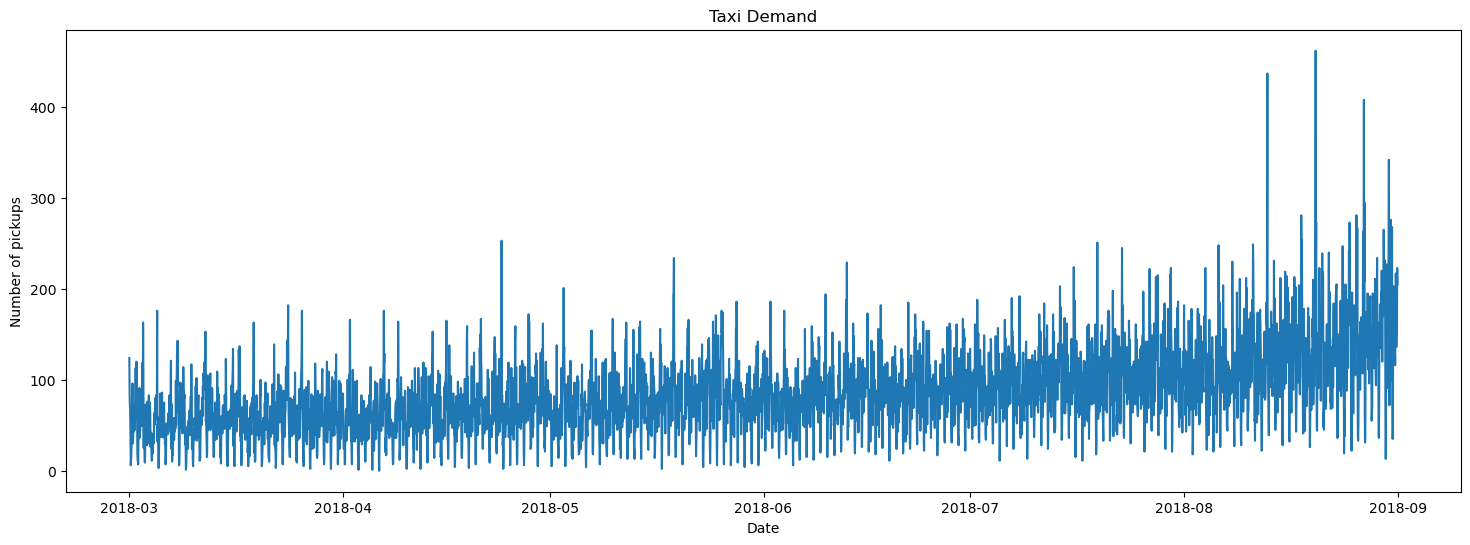

In [9]:
# Visualizing the data
plt.figure(figsize=(18, 6))
plt.plot(resampled_data['num_orders'])
plt.title('Taxi Demand')
plt.xlabel('Date')
plt.ylabel('Number of pickups')
plt.show()

This graph can tell us that we have a bit of variability in the number of pickups. Adding a rolling mean to this could help identify the central tendency of your data over time and make any patterns or trends more apparent.

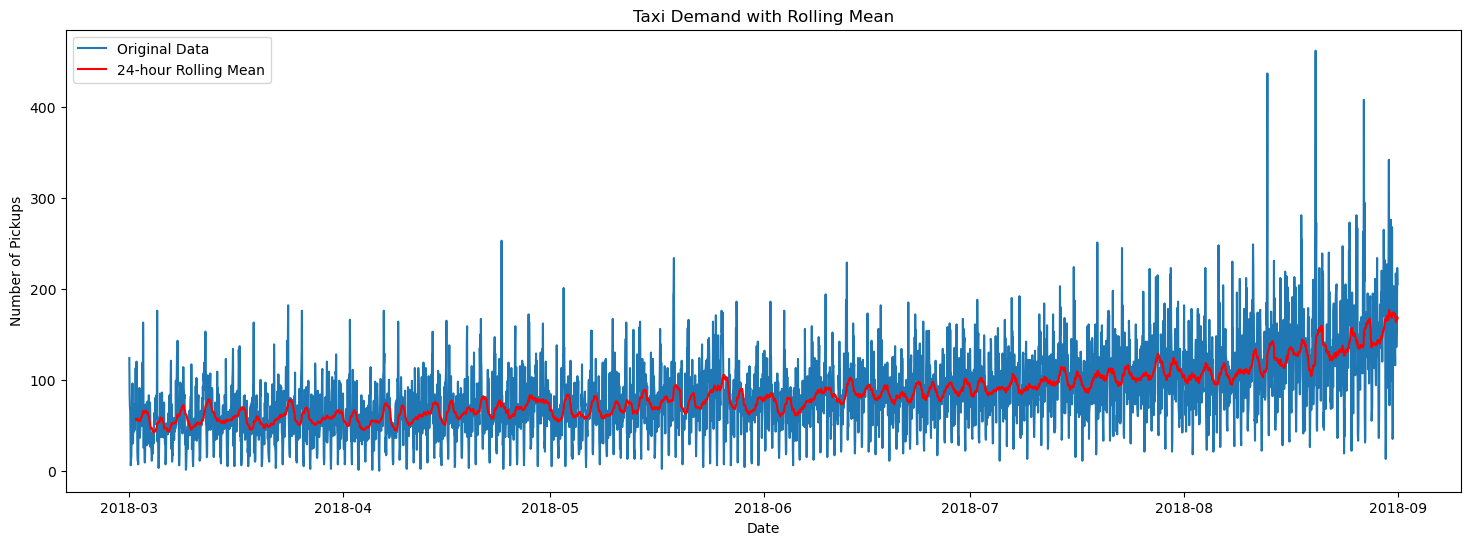

In [10]:
# Calculate the rolling mean with a window of 24 hours
rolling_mean = resampled_data['num_orders'].rolling(window=24).mean()

plt.figure(figsize=(18, 6))
plt.plot(resampled_data['num_orders'], label='Original Data')

plt.plot(rolling_mean, label='24-hour Rolling Mean', color='red')

plt.title('Taxi Demand with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of Pickups')
plt.legend()
plt.show()

To further investigate the data, we can decompose the time series data into its components. This will allow us to see the trend, seasonality, and residuals of the data.

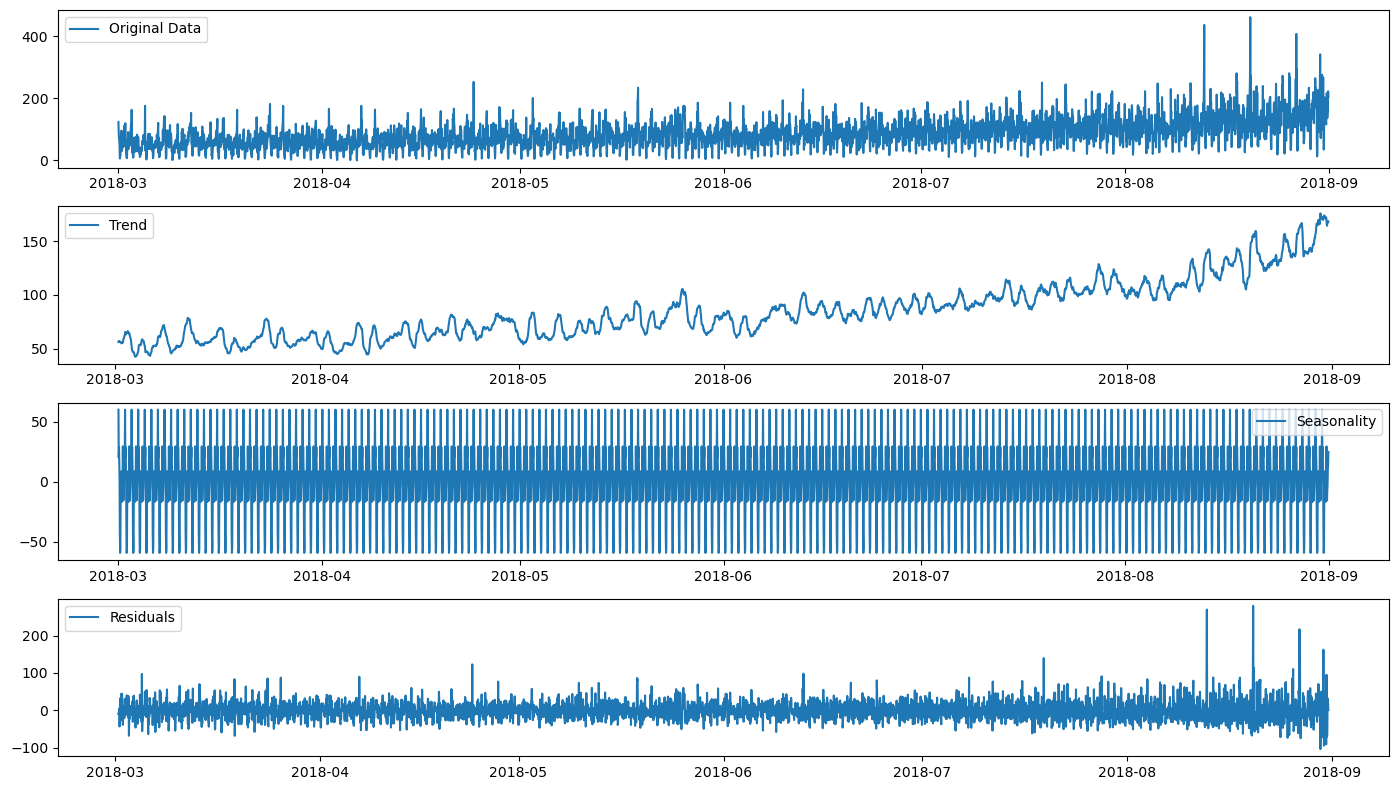

In [11]:
decomposition = seasonal_decompose(resampled_data['num_orders'], model='additive')

# Get the trend, seasonality, and residuals components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components of the time series
plt.figure(figsize=(14, 8))

plt.subplot(411)
plt.plot(resampled_data['num_orders'], label='Original Data')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

- Original Data: This is the actual observed data.

- Trend: This shows the long-term progression of the series. It appears that some form of upward or possibly cyclical trend over the period shown.

- Seasonality: These are patterns that repeat at regular intervals, like daily, weekly, or monthly. It suggests strong, regular periodic spikes, which could correspond to high-demand hours or days.

- Residuals: These are the irregularities or 'noise' that remain after the trend and seasonal components have been removed from the original data.

## Modeling

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(resampled_data, max_lag=24, rolling_mean_size=24)

# Drop the rows with NaN values which may have been introduced by shifting or rolling
resampled_data.dropna(inplace=True)

# Split the data into features and target variables
X = resampled_data.drop('num_orders', axis=1)
y = resampled_data['num_orders']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Now that we have our data prepared for modeling, we are going to star with Linear Regression.

### Linear Regression

In [13]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate the mean absolute error
train_error = mean_absolute_error(y_train, train_predictions)
test_error = mean_absolute_error(y_test, test_predictions)

print("Linear Regresion MAE on training set:", train_error)
print("Linear Regresion MAE on test set:", test_error)


Linear Regresion MAE on training set: 18.729167875312193
Linear Regresion MAE on test set: 29.59725876124111


### Decision Tree

In [14]:
# Set up the parameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=12345)

# Initialize the GridSearchCV object
tree_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit GridSearchCV
tree_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", tree_search.best_params_)
print("Best MAE score:", -tree_search.best_score_)

# Evaluate on the training set
dt_train_predictions = tree_search.predict(X_train)
dt_train_mae = mean_absolute_error(y_train, dt_train_predictions)
print("Decision Tree MAE on training set:", dt_train_mae)

# Evaluate on the test set
dt_test_predictions = tree_search.predict(X_test)
dt_test_mae = mean_absolute_error(y_test, dt_test_predictions)
print("Decision Tree MAE on test set:", dt_test_mae)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best MAE score: 20.6858005973572
Decision Tree MAE on training set: 13.593941426715546
Decision Tree MAE on test set: 35.20335676673407


### Random Forest

In [15]:
# Best parameters from previous GridSearchCV
# These parameters were determined from an extensive search over possible
# combinations of n_estimators, max_depth, min_samples_split, and min_samples_leaf.
# The GridSearchCV code is provided but commented out for efficiency.
# best_params = {
#     'n_estimators': 100,
#     'max_depth': 20,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1
# }


random_forest = RandomForestRegressor(
    n_estimators=100,   # Optimized number of trees
    max_depth=20,       # Optimized maximum depth of trees
    min_samples_split=2, # Optimized minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Optimized minimum number of samples required to be at a leaf node
    random_state=12345  # Set for reproducibility
)


random_forest.fit(X_train, y_train)


rf_test_predictions = random_forest.predict(X_test)
rf_train_predictions = random_forest.predict(X_train)


rf_test_mae = mean_absolute_error(y_test, rf_test_predictions)
rf_train_predictions = mean_absolute_error(y_train, rf_train_predictions)

print("Random Forest MAE on training set:", rf_train_predictions)
print("Random Forest MAE on test set:", rf_test_mae)


# The following commented out code can be used to conduct a new hyperparameter search
# if the environment or data characteristics significantly change.

# rf_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 10],
#     'min_samples_leaf': [1, 4]
# }

# random_forest = RandomForestRegressor(random_state=12345)
# rf_search = GridSearchCV(estimator=random_forest, param_grid=rf_param_grid, cv=5, scoring='neg_mean_absolute_error')
# rf_search.fit(X_train, y_train)
# print("Best parameters:", rf_search.best_params_)
# print("Best MAE score:", -rf_search.best_score_)

Random Forest MAE on training set: 6.108730233268084
Random Forest MAE on test set: 29.07468509023695


## Conclusions

Choosing the right model depends on a balance between performance on the testing set (which indicates generalization) and practical considerations like model complexity, training time, and prediction.

Here's a breakdown of each model based on your results:

- Linear Regression:
Testing MAE: 29.60
It's the simplest model, easy to interpret, and quick to train. If the dataset or the problem complexity grows, it's likely to remain scalable and efficient.
This might be preferable because it's the simplest model that meets the performance requirements. It's also easy to explain to stakeholders and can be used as a baseline for more complex models.

- Decision Tree:
Testing MAE: 35.20
It overfits significantly, as indicated by the large gap between training and testing error.
While it’s interpretable and easy to visualize, this particular model's performance might not justify its use without further tuning or complexity control.

- Random Forest:
Testing MAE: 29.07
It has the lowest MAE on the test set, suggesting better generalization than the other two models, but it's also the most complex and computationally expensive.
Also the MAE on the training set of 6.10 is significantly lower than the MAE on the test set, indicating that the model is overfitting to the training data.

Base on this information we can assume that Linear Regression is the most suitable model for this problem. 